Epoch 1/50
20/20 [==============================] - 2s 22ms/step - loss: 0.2325 - val_loss: 0.1037
Epoch 2/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0489 - val_loss: 0.0505
Epoch 3/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0356 - val_loss: 0.0454
Epoch 4/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0312 - val_loss: 0.0416
Epoch 5/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0279 - val_loss: 0.0409
Epoch 6/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0266 - val_loss: 0.0382
Epoch 7/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0244 - val_loss: 0.0366
Epoch 8/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0228 - val_loss: 0.0349
Epoch 9/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0214 - val_loss: 0.0336
Epoch 10/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0205 - val_loss: 0.0326
Epoch 11/50
20/20 

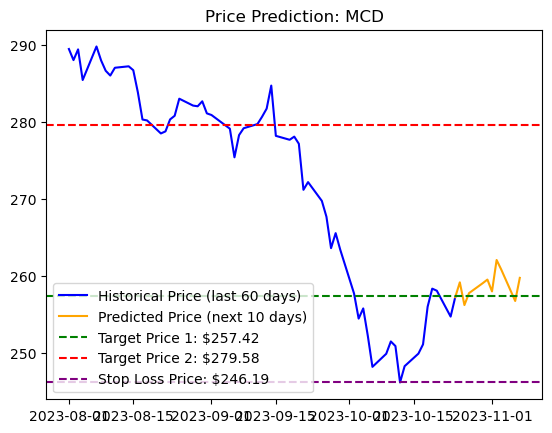

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay
from datetime import datetime

# 下载股票数据
ticker_symbol = 'MCD'  # 股票代码
ticker_data = yf.Ticker(ticker_symbol)
historical_data = ticker_data.history(period='12mo')  # 只考虑最近12个月的数据
data = historical_data[['Close', 'Volume']]  # 使用收盘价和成交量

# 数据归一化
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)  # 数据归一化，方便模型训练

# 准备输入数据
X = data_scaled[:-10]  # 使用除最后10天的数据作为输入
y = data_scaled[10:, 0]  # 预测未来10天的收盘价作为输出
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)  # 划分训练集和测试集

# 创建和训练LSTM模型
model_lstm = Sequential()
model_lstm.add(LSTM(100, input_shape=(X_train.shape[1], 1)))  # LSTM层，100个单元
model_lstm.add(Dense(1))  # 输出层，1个单元
model_lstm.compile(optimizer='adam', loss='mean_squared_error')  # 使用adam优化器和均方误差损失函数
model_lstm.fit(X_train[:, :, np.newaxis], y_train, epochs=50, batch_size=10, validation_data=(X_test[:, :, np.newaxis], y_test), verbose=1, shuffle=False)  # 训练模型

# 创建和训练线性回归模型
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)  # 训练模型

# 创建和训练随机森林模型
model_rf = RandomForestRegressor(n_estimators=100, random_state=12)  # 随机森林模型，100棵树
model_rf.fit(X_train, y_train)  # 训练模型

# 集成预测
lstm_predict = model_lstm.predict(data_scaled[-10:, :, np.newaxis])[:, 0]  # LSTM模型预测
lr_predict = model_lr.predict(data_scaled[-10:])  # 线性回归模型预测
rf_predict = model_rf.predict(data_scaled[-10:])  # 随机森林模型预测
ensemble_predict = (lstm_predict + lr_predict + rf_predict) / 3  # 平均集成预测

# 反归一化预测结果
predicted_prices = scaler.inverse_transform(np.hstack([ensemble_predict.reshape(-1, 1), np.zeros((10, 1))]))[:, 0]  # 反归一化得到原始预测价格

# 寻找过去密集区的中位数价格并确定目标价1
for days in [60, 120, 180]:
    past_data = historical_data['Close'].iloc[-days:]
    price_bins = np.linspace(past_data.min(), past_data.max(), 100)
    price_freq, _ = np.histogram(past_data, bins=price_bins)
    densely_packed_areas_mid_prices = [(price_bins[i] + price_bins[i+1]) / 2 for i in np.argsort(price_freq)[::-1][:3]]
    target_price_1_candidates = [price for price in densely_packed_areas_mid_prices if predicted_prices.min() <= price <= predicted_prices.max()]
    if target_price_1_candidates:
        target_price_1 = min(target_price_1_candidates, key=lambda x: abs(x - predicted_prices.max()))  # 选择离预测最高价最近的作为目标价1
        break
else:  # 如果在过去的数据中没有找到合适的目标价1，则基于最近5天的涨幅百分比来计算目标价1
    recent_growth_rate = (data['Close'].iloc[-1] - data['Close'].iloc[-6]) / data['Close'].iloc[-6]
    target_price_1 = data['Close'].iloc[-1] + recent_growth_rate * (data['Close'].iloc[-1] - data['Close'].iloc[-6])

# 确定目标价2和止损价
target_price_2 = predicted_prices.max()  # 预测价格的最高点作为目标价2
stop_loss_price = historical_data['Close'].iloc[-15:].min()  # 最近15天的最低价作为止损价
# 如果目标价2小于或等于目标价1，或者风险收益比不合理，则调整目标价2和止损价
max_iterations = 10  # 设置最大迭代次数以避免无限循环
iterations = 0  # 初始化迭代计数器
while (target_price_2 <= target_price_1 or 
       (target_price_1 - data['Close'].values[-1]) / (data['Close'].values[-1] - stop_loss_price) < 2) and iterations < max_iterations:
    target_price_2 = max(target_price_2, target_price_1 + 2 * (data['Close'].values[-1] - stop_loss_price))  # 调整目标价2以保证风险收益比
    stop_loss_price = min(stop_loss_price, data['Close'].values[-1] - (target_price_1 - data['Close'].values[-1]) / 2)  # 调整止损价以保证风险收益比
    iterations += 1  # 更新迭代计数器

# 绘图
fig, ax = plt.subplots()
# 绘制最近60天的历史价格
ax.plot(data.index[-60:], data['Close'].values[-60:], label='Historical Price (last 60 days)', color='blue')  # 最近60天的历史价格

# 未来10个交易日的日期
future_dates = pd.date_range(start=data.index[-1] + BDay(1), periods=10, freq='B')  # 未来10个交易日的日期

# 连接最后一天的历史价格和第一天的预测价格
connected_dates = data.index[-1:].append(future_dates)  # 连接日期
connected_prices = np.concatenate((data['Close'].values[-1:], predicted_prices))  # 连接价格

# 绘制预测价格
ax.plot(connected_dates, connected_prices, label='Predicted Price (next 10 days)', color='orange')  # 预测价格

# 绘制目标价和止损价
ax.axhline(y=target_price_1, color='green', linestyle='--', label=f'Target Price 1: ${target_price_1:.2f}')
ax.axhline(y=target_price_2, color='red', linestyle='--', label=f'Target Price 2: ${target_price_2:.2f}')
ax.axhline(y=stop_loss_price, color='purple', linestyle='--', label=f'Stop Loss Price: ${stop_loss_price:.2f}')

ax.legend()
plt.title(f'Price Prediction: {ticker_symbol}')
plt.show()


In [2]:
pip install tensorflow



     ------------------------------------ 284.1/284.1 MB 624.8 kB/s eta 0:00:00
     ---------------------------------------- 3.7/3.7 MB 7.5 MB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 7.3 MB/s eta 0:00:00
     --------------------------------------- 24.4/24.4 MB 17.7 MB/s eta 0:00:00
     -------------------------------------- 65.5/65.5 kB 272.1 kB/s eta 0:00:00
     -------------------------------------- 57.5/57.5 kB 335.0 kB/s eta 0:00:00
     -------------------------------------- 938.6/938.6 kB 4.3 MB/s eta 0:00:00
     ------------------------------------ 430.5/430.5 kB 896.1 kB/s eta 0:00:00
     ---------------------------------------- 5.5/5.5 MB 8.6 MB/s eta 0:00:00
     -------------------------------------- 130.2/130.2 kB 3.9 MB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 8.4 MB/s eta 0:00:00
     -------------------------------------- 440.7/440.7 kB 3.4 MB/s eta 0:00:00
